# KNN Comparsion of Different Transformer Models

In [1]:
import sys
import os
sys.path.append('.')
from baselines.datasets import representations_from_df, labels_from_df 
from baselines.io import load_baseline_model

data_folder = "BIOSCAN_5M_DNA_experiments/data"
 
#"BarcodeBERT_soft_penalty/data"

for model_name in ["BarcodeBERT", "DNABERT-2", "DNABERT-S", "NT", "Hyena_DNA", "DNABERT"]:
    if model_name == "BarcodeBERT":
        checkpoints = {"BarcodeBERT-5M":"/h/pmillana/projects/BIOSCAN_5M_DNA_experiments/model_checkpoints/8_4_4/checkpoint_pretraining.pt",
                       #"BarcodeBERT-1.5M":"/scratch/ssd004/scratch/pmillana/checkpoints/canada-1.5M/k4-4-4_w1.0_m1.0_r0.0.pt",
                      }
        
        for ckpt_name in checkpoints:
            checkpoint = checkpoints[ckpt_name]
            embedder = load_baseline_model(model_name, checkpoint_path=checkpoint, new_vocab=False)

            print(ckpt_name)

            embedder.name = model_name
            
            # Ensure model is in eval mode
            embedder.model.eval()
        
            trainable_params = sum(	p.numel() for p in embedder.model.parameters() if p.requires_grad)
        
            print(f"Number of trainable parameters: {trainable_params}")
            
            for file in ["unseen", "supervised_train", "supervised_test", "supervised_val"]: 
                filename = f"/h/pmillana/projects/{data_folder}/{file}.csv"
                embeddings = representations_from_df(filename, embedder, dataset="BIOSCAN-5M", target="processid") #dataset= "BIOSCAN-5M"
                print(embeddings.shape)

            os.rename(f"/scratch/ssd004/scratch/pmillana/embeddings/embeddings/BIOSCAN-5M/BarcodeBERT", 
                      f"/scratch/ssd004/scratch/pmillana/embeddings/embeddings/BIOSCAN-5M/{ckpt_name}")
            
    else:
        embedder = load_baseline_model(model_name)
    
        embedder.name = model_name
        
        # Ensure model is in eval mode
        embedder.model.eval()
    
        trainable_params = sum(	p.numel() for p in embedder.model.parameters() if p.requires_grad)
    
        print(f"Number of trainable parameters: {trainable_params}")
        
        for file in ["unseen", "supervised_train", "supervised_test", "supervised_val"]: 
            filename = f"/h/pmillana/projects/{data_folder}/{file}.csv"
            embeddings = representations_from_df(filename, embedder, dataset="BIOSCAN-5M") #dataset= "BIOSCAN-5M"
            print(embeddings.shape)

Using device: cuda

Loading model from /h/pmillana/projects/BIOSCAN_5M_DNA_experiments/model_checkpoints/8_4_4/checkpoint_pretraining.pt

Loading model from /h/pmillana/projects/BIOSCAN_5M_DNA_experiments/model_checkpoints/8_4_4/checkpoint_pretraining.pt
Loaded model from /h/pmillana/projects/BIOSCAN_5M_DNA_experiments/model_checkpoints/8_4_4/checkpoint_pretraining.pt
BarcodeBERT-5M
Number of trainable parameters: 129478144
Using device: cuda
Calculating embeddings for BarcodeBERT
/scratch/ssd004/scratch/pmillana/embeddings/embeddings/BIOSCAN-5M/BarcodeBERT/unseen.pickle


0it [00:00, ?it/s]

(3396, 768)
Using device: cuda
Calculating embeddings for BarcodeBERT
/scratch/ssd004/scratch/pmillana/embeddings/embeddings/BIOSCAN-5M/BarcodeBERT/supervised_train.pickle


0it [00:00, ?it/s]

(117991, 768)
Using device: cuda
Calculating embeddings for BarcodeBERT
/scratch/ssd004/scratch/pmillana/embeddings/embeddings/BIOSCAN-5M/BarcodeBERT/supervised_test.pickle


0it [00:00, ?it/s]

(18348, 768)
Using device: cuda
Calculating embeddings for BarcodeBERT
/scratch/ssd004/scratch/pmillana/embeddings/embeddings/BIOSCAN-5M/BarcodeBERT/supervised_val.pickle


0it [00:00, ?it/s]

(6585, 768)


/h/pmillana/miniconda3/envs/hyenadna/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/fs01/home/pmillana/projects/BarcodeBERT/baselines/models/dnabert2.py:203: UserWarning: Unable to import Triton; defaulting MosaicBERT attention                 implementation to pytorch (this will reduce throughput when using this model).
  self.self = BertUnpadSelfAttention(config)


Number of trainable parameters: 117068544
Using device: cuda
Calculating embeddings for DNABERT-2
/scratch/ssd004/scratch/pmillana/embeddings/embeddings/BIOSCAN-5M/DNABERT-2/unseen.pickle
We found the file /scratch/ssd004/scratch/pmillana/embeddings/embeddings/BIOSCAN-5M/DNABERT-2/unseen.pickle. It seems that we have computed the embeddings ... 

Loading the embeddings from that file
(3396, 768)
Using device: cuda
Calculating embeddings for DNABERT-2
/scratch/ssd004/scratch/pmillana/embeddings/embeddings/BIOSCAN-5M/DNABERT-2/supervised_train.pickle
We found the file /scratch/ssd004/scratch/pmillana/embeddings/embeddings/BIOSCAN-5M/DNABERT-2/supervised_train.pickle. It seems that we have computed the embeddings ... 

Loading the embeddings from that file
(117991, 768)
Using device: cuda
Calculating embeddings for DNABERT-2
/scratch/ssd004/scratch/pmillana/embeddings/embeddings/BIOSCAN-5M/DNABERT-2/supervised_test.pickle
We found the file /scratch/ssd004/scratch/pmillana/embeddings/embed

### This notebook Compares the embedding performance on the 'BIOSCAN-5M' dataset, of seven different DNA barcode-based models: BarcodeBERT-1M, BarcodeBERT-5M, DNABERT, DNABERT-2, DNABERT-S, Hyena_DNA and NT. To demonstrate each model's performance, a KNN (K-Nearest-Neighbor) analysis of the embeddings produced by each model is completed and the results are plotted.

In [2]:
%matplotlib inline
import os
import pickle
import cProfile
import pstats
import warnings

import numpy as np
import sklearn
from sklearn.neighbors import KNeighborsClassifier, KDTree
from scipy.spatial import distance
from matplotlib import pyplot as plt
from obj_knn import FinBOL_GBOL
from tqdm import tqdm

warnings.filterwarnings("ignore")

dataset = "BIOSCAN-5M"
data_folder = "BIOSCAN_5M_DNA_experiments/data"

### Each sample is labeled at seven taxonomic ranks: class, order, family, subfamily, tribe, genus, and species. 

In [3]:
rank_list = ["class", "order", "family", "genus"]
encoders = ["BarcodeBERT-5M", "BarcodeBERT-1.5M", "DNABERT-2", "DNABERT-S", "Hyena_DNA", "NT", "DNABERT"]

# Creating the embeddings dictionary to hold all the FinBOL vs GBOL embedding/label data 
embeddings = {}
for encoder in encoders:
    embeddings[encoder] = {}

### The 'FinBOL VS GBOL' dataset consists of two subsets: FinBOL, which consists of 35,623 DNA barcode samples from Finland, and GBOL, which contains 27,071 samples from Germany. for the purposes of this demonstration the FinBOL and GBOL partitions will be denoted as 'Train' and 'Test' within the code respectively.

In [4]:
for encoder in encoders:
    # reading the FinBOL embeddings
    embeddings_folder = f"/scratch/ssd004/scratch/pmillana/embeddings/embeddings/{dataset}"
    with open(f"{embeddings_folder}/{encoder}/supervised_train.pickle", "rb") as train_handle:
        embeddings[encoder]["Train"] = pickle.load(train_handle)

    # reading the GBOL embeddings
    with open(f"{embeddings_folder}/{encoder}/unseen.pickle", "rb") as test_handle:
        embeddings[encoder]["Test"] = pickle.load(test_handle)

print('Partition lengths:')
print("Train: ", len(embeddings[encoder]["Train"]['ids']))
print("Test: ", len(embeddings[encoder]["Test"]['ids']))


Partition lengths:
Train:  117991
Test:  3396


### Each model encodes a different represenation of the data it was given. To see this, and check that all the data from each model was downloaded properly, a small slice of each encoder's first three embeddings is shown below.

In [5]:
# checking embeddings have been loaded correctly for each model
for encoder in encoders:
    print(encoder)
    for x in (embeddings[encoder]["Train"]['data'][0:3]):
        print(x[0:5])
    print('')

BarcodeBERT-5M
[ 0.09214871 -0.28794685  0.53928757  0.9168416   1.3121055 ]
[ 0.831489   -0.3615735   0.76890117  1.3734493   1.3992038 ]
[ 1.4686996  -1.5243493  -0.38512456 -0.9432046   1.3044655 ]

BarcodeBERT-1.5M
[-0.53626347  0.09011476  0.42271817 -0.48337653 -0.4285088 ]
[ 0.63842535  0.4025818   0.48704904 -0.5684968  -0.02414471]
[-0.2542615   0.9730221  -0.78906757  0.8005601  -0.78792286]

DNABERT-2
[-0.04637298  0.04902313  0.08496991 -0.23243466 -0.05571817]
[-0.057013    0.09968127  0.04312181 -0.10065868 -0.08347727]
[-0.02494159  0.09553736  0.20338997 -0.29023287  0.10629106]

DNABERT-S
[-0.1597295   0.02266525  0.08694088 -0.04299423 -0.04086146]
[-0.14647585  0.0559435  -0.02330555 -0.10474078  0.06707122]
[-0.08246402  0.07391788  0.05502942 -0.12959167  0.02660595]

Hyena_DNA
[-0.8045766   0.29781792 -0.6705309   5.24395     0.38879412]
[-0.80563927  0.28470957 -0.7307025   5.2341      0.42421266]
[-0.74916196  0.27695835 -0.64270693  5.2096686   0.40003225]

NT


### After reading the embedding files from each model, the labels associated with each embeddings must be further processed in order to be used in the KNN analysis. A single sample from the file contains a 'data' segment (the embedding), and a 'ids' segments which contains a label that holds several different kinds of information about that specific sample. It is this 'ids' segment that must be seperated into several more specific segments including the label of that sample at each of the seven taxonomic ranks listed above.

In [6]:
import pandas as pd

train = pd.read_csv(f"/h/pmillana/projects/{data_folder}/supervised_train.csv")
test = pd.read_csv(f"/h/pmillana/projects/{data_folder}/unseen.csv")

df_dict = {'Train': train, 'Test':test}

for encoder in encoders:
    for part in ('Train', 'Test'):
        df = df_dict[part]
        for rank in rank_list:
            if rank != 'class':
                taxa = rank + '_name'
            else:
                taxa = rank
            processid_to_taxa = dict(zip(df['processid'], df[taxa]))
            # extract label at each taxonomic rank
            embeddings[encoder][part][rank] = [processid_to_taxa.get(processid, None) for processid in embeddings[encoder][part]['ids']]

### After processing the initial label, each sample now has 10 distinct labels that can be used to group and identify them. Below is an example of the labels concerning the first sample of the FinBOL dataset

In [7]:
# displaying all the new labels
for x in embeddings['NT']['Train'].keys():
    if x != 'data':
        print(f"{x}:{' '*(10-len(x))}" ,embeddings['Hyena_DNA']['Train'][x][13])

ids:        YDBB5936-21
class:      Arachnida
order:      Mesostigmata
family:     Trachytidae
genus:      Polyaspinus


In [8]:
df_dict['Train'][df_dict['Train']["processid"]=="YDBB5936-21"]

,processid,phylum,class,order_name,family_name,subfamily_name,genus_name,species_name,dna_bin,nucleotides,split,phylum_index,class_index,order_index,family_index,subfamily_index,genus_index,species_index,dna_bin_index
13,YDBB5936-21,Arthropoda,Arachnida,Mesostigmata,Trachytidae,unassigned Trachytidae,Polyaspinus,Polyaspinus higginsi,BOLD:AEN4118,TATATATTTAGTATTCAGAGCATGAGCTGGAATAGCTGGAACAGCT...,train,0,0,10,269,305,422,426,4670


### A single dictionary called 'embeddings' now holds all the data and labels associated with each sample, for each partition, for each model. This example shows the general tree structure for how the data is accessed for each model where each key holds another dictionary except for those at the lowest level which are lists.

In [9]:
print(embeddings.keys())
print(embeddings['NT'].keys())
print(embeddings['NT']['Test'].keys())

dict_keys(['BarcodeBERT-5M', 'BarcodeBERT-1.5M', 'DNABERT-2', 'DNABERT-S', 'Hyena_DNA', 'NT', 'DNABERT'])
dict_keys(['Train', 'Test'])
dict_keys(['data', 'ids', 'class', 'order', 'family', 'genus'])


# KNN Analysis
the results following the section as well as the associated output files for each model have been made using k=10 for the KNN analysis

In [10]:
# dictionaries for storing results and knn probability data
results = {}
label_probs = {}

for encoder in encoders:
    results[encoder] = {}

    # using tqdm to display progress bar for each model
    for i in tqdm(range(len(rank_list)),desc=f"{encoder}{' '*(15-len(encoder))}"):
        rank=rank_list[i]
        results[encoder][rank] = {}

        # creating a number mapping for the labels at the current taxonomic rank to use for knn analysis
        all_labels = sorted(list(set(embeddings[encoder]['Test'][rank]+embeddings[encoder]['Train'][rank])))
        embeddings[encoder]['Train']['mapped_y_train'] = np.array([all_labels.index(el) for el in embeddings[encoder]['Train'][rank]])
        embeddings[encoder]['Test']['mapped_y_test'] = np.array([all_labels.index(el) for el in embeddings[encoder]['Test'][rank]])

        # creating and initializing the KNN classifier with k=10, leaf size=2000 and using maximum number of threads for analysis
        clf = KNeighborsClassifier(n_neighbors=1, n_jobs=36, metric="cosine")
        clf.fit(embeddings[encoder]['Train']['data'], embeddings[encoder]['Train']['mapped_y_train'])
        
        for partition_name, X_part, y_part in [#('Train', embeddings[encoder]['Train']['data'], embeddings[encoder]['Train']['mapped_y_train']),
                                               ('Test', embeddings[encoder]['Test']['data'], embeddings[encoder]['Test']['mapped_y_test'])]:
            
            # set of possible labels the classifier can choose from
            curr_labels = sorted(list(set(embeddings[encoder]['Train'][rank])))

            y_pred = clf.predict(X_part)
            pred_labels = [all_labels.index(curr_labels[i]) for i in y_pred]

            # record accuracy metrics
            res_part = {}
            res_part["count"] = len(y_part)
            # Note that these evaluation metrics have all been converted to percentages
            res_part["accuracy"] = 100.0 * sklearn.metrics.accuracy_score(y_part, pred_labels)
            res_part["accuracy-balanced"] = 100.0 * sklearn.metrics.balanced_accuracy_score(y_part, pred_labels)
            res_part["f1-micro"] = 100.0 * sklearn.metrics.f1_score(y_part, pred_labels, average="micro")
            res_part["f1-macro"] = 100.0 * sklearn.metrics.f1_score(y_part, pred_labels, average="macro")
            res_part["f1-support"] = 100.0 * sklearn.metrics.f1_score(y_part, pred_labels, average="weighted")
            results[encoder][rank][partition_name] = res_part
            print(res_part["accuracy"])
            

BarcodeBERT-5M :  25%|██▌       | 1/4 [00:17<00:52, 17.60s/it]

99.64664310954063


BarcodeBERT-5M :  50%|█████     | 2/4 [00:34<00:34, 17.04s/it]

99.17550058892816


BarcodeBERT-5M :  75%|███████▌  | 3/4 [00:51<00:17, 17.13s/it]

91.96113074204946


BarcodeBERT-5M : 100%|██████████| 4/4 [01:12<00:00, 18.23s/it]


47.02591283863369


BarcodeBERT-1.5M:  25%|██▌       | 1/4 [00:16<00:50, 16.89s/it]

99.97055359246173


BarcodeBERT-1.5M:  50%|█████     | 2/4 [00:34<00:34, 17.40s/it]

99.88221436984688


BarcodeBERT-1.5M:  75%|███████▌  | 3/4 [00:52<00:17, 17.56s/it]

91.07773851590106


BarcodeBERT-1.5M: 100%|██████████| 4/4 [01:14<00:00, 18.56s/it]


40.95995288574794


DNABERT-2      :  25%|██▌       | 1/4 [00:17<00:51, 17.08s/it]

97.7326266195524


DNABERT-2      :  50%|█████     | 2/4 [00:34<00:34, 17.03s/it]

83.45111896348646


DNABERT-2      :  75%|███████▌  | 3/4 [00:51<00:17, 17.26s/it]

49.8527679623086


DNABERT-2      : 100%|██████████| 4/4 [01:14<00:00, 18.51s/it]


16.07773851590106


DNABERT-S      :  25%|██▌       | 1/4 [00:16<00:49, 16.37s/it]

97.37926972909305


DNABERT-S      :  50%|█████     | 2/4 [00:33<00:33, 16.74s/it]

87.10247349823321


DNABERT-S      :  75%|███████▌  | 3/4 [00:50<00:17, 17.03s/it]

56.03651354534747


DNABERT-S      : 100%|██████████| 4/4 [01:12<00:00, 18.11s/it]


18.050647820965843


Hyena_DNA      :  25%|██▌       | 1/4 [00:09<00:27,  9.25s/it]

96.73144876325088


Hyena_DNA      :  50%|█████     | 2/4 [00:18<00:18,  9.25s/it]

89.72320376914017


Hyena_DNA      :  75%|███████▌  | 3/4 [00:28<00:09,  9.39s/it]

60.39458186101295


Hyena_DNA      : 100%|██████████| 4/4 [00:42<00:00, 10.59s/it]


20.49469964664311


NT             :  25%|██▌       | 1/4 [00:14<00:42, 14.06s/it]

97.96819787985865


NT             :  50%|█████     | 2/4 [00:28<00:28, 14.27s/it]

89.5170789163722


NT             :  75%|███████▌  | 3/4 [00:42<00:14, 14.25s/it]

58.00942285041225


NT             : 100%|██████████| 4/4 [01:01<00:00, 15.42s/it]


19.994110718492344


DNABERT        :  25%|██▌       | 1/4 [00:16<00:50, 16.93s/it]

97.85041224970553


DNABERT        :  50%|█████     | 2/4 [00:34<00:34, 17.03s/it]

93.96348645465254


DNABERT        :  75%|███████▌  | 3/4 [00:52<00:17, 17.53s/it]

65.5771495877503


DNABERT        : 100%|██████████| 4/4 [01:14<00:00, 18.50s/it]

25.94228504122497


# Results
### The results of the KNN analysis are shown below in two different formats
NOTE: The metric displayed in the graphs below is accuracy. Several other metrics have been calculated such as the balanced accuracy, all of which are stored in the 'results' dictionary.

In [11]:
import json
with open(f"results_{dataset}.json", "w") as f:
    json.dump(results, f)

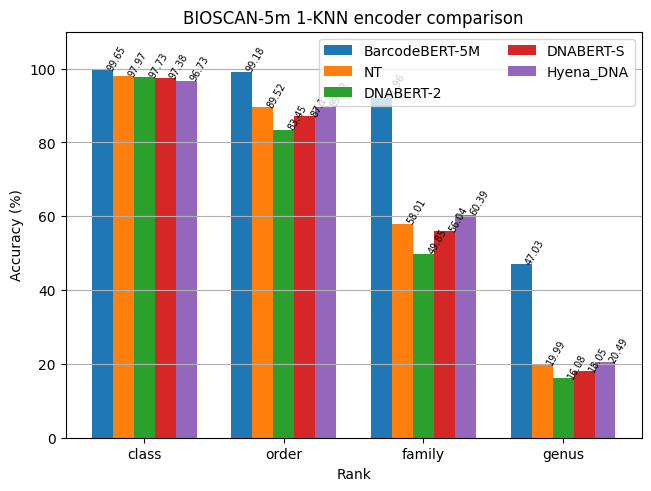

In [12]:
%matplotlib inline
import os
import pickle
import cProfile
import pstats
import warnings

import numpy as np
import sklearn
from sklearn.neighbors import KNeighborsClassifier, KDTree
from scipy.spatial import distance
from matplotlib import pyplot as plt
from obj_knn import FinBOL_GBOL
from tqdm import tqdm

warnings.filterwarnings("ignore")

dataset = "BIOSCAN-5M"
#data_folder = "BIOSCAN_5M_DNA_experiments/data"

import json

with open(f"results_{dataset}.json", "r") as f:
    results = json.load(f)

rank_list = ["class", "order", "family", "genus"]
encoders = ["BarcodeBERT-5M", "DNABERT-2", "DNABERT-S", "Hyena_DNA", "NT"]#, "DNABERT"]

x = np.arange(len(rank_list))  # the label locations
encoders = sorted(encoders,key=lambda x:results[x]['class']['Test']['accuracy'],reverse=True)
width = 0.15  # the width of the bars
multiplier = -1

graph = {}
for encoder in encoders:
    graph[encoder] = [round(results[encoder][rank]['Test']['accuracy'], 2) for rank in rank_list]

fig, ax = plt.subplots(layout='constrained')

for rank, measurement in graph.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=rank)
    multiplier += 1

for i in range(len(x)):
    for j, encoder in enumerate(encoders):
        plt.text(i+offset+(j-multiplier)*(width)+0.1, graph[encoder][i], graph[encoder][i], ha='center', rotation=60, fontsize='x-small')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy (%)')
ax.set_xlabel('Rank')

ax.set_title('BIOSCAN-5m 1-KNN encoder comparison')
ax.set_xticks(x + width, rank_list)
ax.legend(loc='upper right', ncols=2)
ax.set_ylim(0, 110)
plt.grid(axis="y")

plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


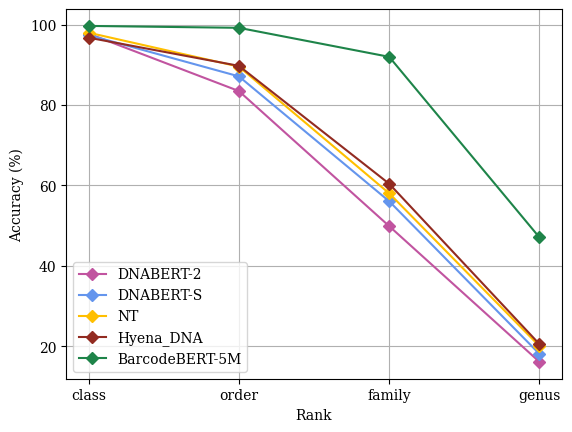

In [14]:
import matplotlib.pyplot as plt
import json


plt.rcParams["font.family"] = "serif"
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=["#C154A0", "#6495ED", "#FFBF00", "#922B21", "#1E8449", "#40E0D0", "#C18420"])


encoders = ["DNABERT-2", "DNABERT-S", "NT", "Hyena_DNA",  "BarcodeBERT-5M"] #, "BarcodeBERT-1.5M"]

for encoder in encoders:
    plt.plot(rank_list, graph[encoder],"D-", label = encoder)
#plt.title('1NN-probing at different taxonomic levels')
plt.xlabel('Rank')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()
plt.savefig("BIOSCAN_5M_KNN_by_rank_cosine.eps", dpi=150)
plt.savefig("BIOSCAN_5M_KNN_by_rank_cosine.jpg", dpi=150)
plt.show()

In [15]:
import pickle
import pandas as pd

encoders = ["BarcodeBERT-5M", "DNABERT-2", "DNABERT-S", "NT", "Hyena_DNA"]
experiment_1 = "BIOSCAN-5M"
experiment_2 = "paper"
data_folder = "BIOSCAN_5M_DNA_experiments/data"

for encoder in encoders:
    for file in ["unseen", "supervised_test"]: 
        filename = f"/scratch/ssd004/scratch/pmillana/embeddings/embeddings/{experiment_1}/{encoder}/{file}.pickle"
        with open(filename, "rb") as handle:
            embeddings = pickle.load(handle)
            print(embeddings["data"].shape)
            processids = embeddings["ids"]

        filename = f"/scratch/ssd004/scratch/pmillana/embeddings/embeddings/{experiment_2}/{encoder}/{file}.pickle"
        with open(filename, "rb") as handle:
            embeddings = pickle.load(handle)
            print(embeddings["data"].shape)
            species = embeddings["ids"]

        df = pd.read_csv(f"/h/pmillana/projects/{data_folder}/{file}.csv")
        taxa = 'species_name'
        processid_to_taxa = dict(zip(df['processid'], df[taxa]))

        new_species = [processid_to_taxa.get(processid, None) for processid in processids]
        for i in range(len(processids)):
            print(species[i], new_species[i])
            if species[i] != new_species[i]:
                break
                print(i, processids[i])
         

(3396, 768)
(3396, 768)
Allocladius sp. 1ES Phytomyptera Janzen7372
(18348, 768)
(18349, 768)
Glyphidocera fidem Epidamaeus arcticola
(3396, 768)
(3396, 768)
Allocladius sp. 1ES Phytomyptera Janzen7372
(18348, 768)
(18349, 768)
Glyphidocera fidem Epidamaeus arcticola
(3396, 768)
(3396, 768)
Allocladius sp. 1ES Phytomyptera Janzen7372
(18348, 768)
(18349, 768)
Glyphidocera fidem Epidamaeus arcticola
(3396, 512)
(3396, 512)
Allocladius sp. 1ES Phytomyptera Janzen7372
(18348, 512)
(18349, 512)
Glyphidocera fidem Epidamaeus arcticola
(3396, 128)
(3396, 128)
Allocladius sp. 1ES Phytomyptera Janzen7372
(18348, 128)
(18349, 128)
Glyphidocera fidem Epidamaeus arcticola
